In [1]:
import sys
sys.path.append('../')

import optim_utils

import pandas as pd
from tqdm.notebook import tqdm

In [2]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [3]:
passes_df = pd.read_csv(PASSES_DF_PATH)

In [4]:
xt_table = pd.read_csv(XT_PLOT_PATH)
pitch_length, pitch_width = pd.read_csv(METADATA_PATH)[['pitch_length', 'pitch_width']].values[0]
threat_map = optim_utils.ThreatMap(xt_table, pitch_length, pitch_width)

In [5]:
negative_frames = optim_utils.all_negative_dxt_frames(passes_df, threat_map)
passes_df = passes_df[~passes_df['frame'].isin(negative_frames)]

# Defender Evaluation

In [8]:
pass_results, agg_results = optim_utils.optimize_defender(passes_df, 10082, threat_map, pitch_length, pitch_width, radius=3, grid_res=5, mode='softmax')

In [9]:
agg_results

,improvement,improvement_perc,distance
mean,0.000037,23.09372,1.082740
median,0.000000,0.00000,0.000000
std,0.000138,163.61304,1.362914


# Apply to all defenders

In [10]:
player_ids = passes_df[~passes_df['tracking.is_ball']]['tracking.object_id'].unique()

In [ ]:
def_passes = {}
def_stats = {}
def_counts = {}
for player_id in tqdm(player_ids):
    def_passes[player_id], def_stats[player_id] = optim_utils.optimize_defender(passes_df, player_id, threat_map, pitch_length, pitch_width, radius=3, grid_res=5, mode='softmax')
    def_counts[player_id] = len(def_passes[player_id])

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
results = pd.concat(def_stats).reset_index().rename(columns={'level_0': 'player_id', 'level_1': 'metric'})
means = results[results['metric'] == 'mean'].drop(columns='metric')
medians = results[results['metric'] == 'median'].drop(columns='metric')
stds = results[results['metric'] == 'std'].drop(columns='metric')
means['count'] = means['player_id'].map(def_counts)
medians['count'] = medians['player_id'].map(def_counts)
stds['count'] = stds['player_id'].map(def_counts)

In [ ]:
means_filt = means[means['count'] >= 100]
medians_filt = medians[medians['count'] >= 100]

In [ ]:
means_filt.sort_values('improvement', ascending=False).head(10)

,player_id,improvement,improvement_perc,distance,count
0,7604,0.0,0.0,0.0,532
45,7863,0.0,0.0,0.0,662
81,22103,0.0,0.0,0.0,106
78,12246,0.0,0.0,0.0,147
75,12654,0.0,0.0,0.0,166
72,2548,0.0,0.0,0.0,162
69,2106,0.0,0.0,0.0,124
66,10916,0.0,0.0,0.0,377
63,7387,0.0,0.0,0.0,688
60,31930,0.0,0.0,0.0,573


<Axes: >

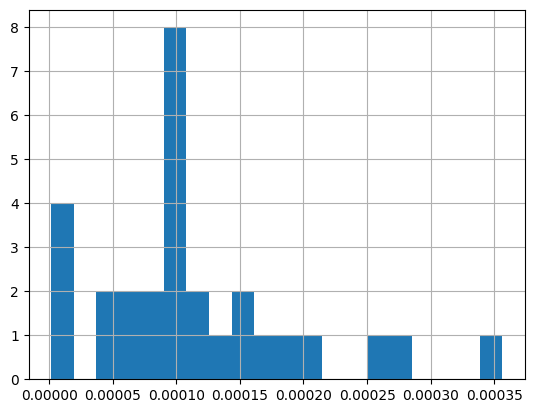

In [ ]:
means_filt['improvement'].hist(bins=20)